# 量化金融预测

In [47]:
# 导入模块
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss, mean_squared_log_error
import tqdm, sys, os, gc, argparse, warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [2]:
# 数据导入
train_file = os.listdir('../input/train/')
test_file = os.listdir('../input/test/')
train = pd.DataFrame()
test = pd.DataFrame()
# 读取训练数据
for file in train_file:
    tmp = pd.read_csv('../input/train/'+file)
    tmp['file'] = file
    train = pd.concat([train, tmp], axis=0, ignore_index=True)
# 读取测试数据
for file in test_file:
    tmp = pd.read_csv('../input/test/'+file)
    tmp['file'] = file
    test = pd.concat([test, tmp], axis=0, ignore_index=True)


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239880 entries, 0 to 239879
Data columns (total 33 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   uuid          239880 non-null  int64  
 1   date          239880 non-null  int64  
 2   time          239880 non-null  object 
 3   sym           239880 non-null  int64  
 4   n_close       239880 non-null  float64
 5   amount_delta  239880 non-null  float64
 6   n_midprice    239880 non-null  float64
 7   n_bid1        239880 non-null  float64
 8   n_bsize1      239880 non-null  float64
 9   n_bid2        239880 non-null  float64
 10  n_bsize2      239880 non-null  float64
 11  n_bid3        239880 non-null  float64
 12  n_bsize3      239880 non-null  float64
 13  n_bid4        239880 non-null  float64
 14  n_bsize4      239880 non-null  float64
 15  n_bid5        239880 non-null  float64
 16  n_bsize5      239880 non-null  float64
 17  n_ask1        239880 non-null  float64
 18  n_as

In [4]:
train.head()

,uuid,date,time,sym,n_close,amount_delta,n_midprice,n_bid1,n_bsize1,n_bid2,...,n_ask4,n_asize4,n_ask5,n_asize5,label_5,label_10,label_20,label_40,label_60,file
0,0,0,09:40:03,1,-0.007605,2081.0,-0.009506,-0.011407,0.000222,-0.015209,...,0.003802,0.000162,0.007605,0.000262,1,0,0,0,1,snapshot_sym1_date0_am.csv
1,1,0,09:40:06,1,-0.011407,129268.0,-0.009506,-0.011407,0.000221,-0.015209,...,0.003802,0.000163,0.007605,0.000264,1,0,0,0,1,snapshot_sym1_date0_am.csv
2,2,0,09:40:09,1,-0.007605,76098.0,-0.009506,-0.011407,0.000221,-0.015209,...,0.003802,0.000163,0.007605,0.000265,0,0,0,0,1,snapshot_sym1_date0_am.csv
3,3,0,09:40:12,1,-0.007605,2613280.0,-0.009506,-0.011407,0.000174,-0.015209,...,0.003802,0.000162,0.007605,0.000265,0,0,0,0,1,snapshot_sym1_date0_am.csv
4,4,0,09:40:15,1,-0.011407,327615.0,-0.009506,-0.011407,0.000112,-0.015209,...,0.003802,0.000162,0.007605,0.000265,0,0,0,0,1,snapshot_sym1_date0_am.csv


In [5]:
train.tail()

,uuid,date,time,sym,n_close,amount_delta,n_midprice,n_bid1,n_bsize1,n_bid2,...,n_ask4,n_asize4,n_ask5,n_asize5,label_5,label_10,label_20,label_40,label_60,file
239875,1994,9,14:49:45,1,0.0,618749.0,0.001845,0.0,0.000202,-0.00369,...,0.01476,0.00067,0.01845,0.000495,1,1,1,1,1,snapshot_sym1_date9_pm.csv
239876,1995,9,14:49:48,1,0.0,129328.0,0.001845,0.0,0.000201,-0.00369,...,0.01476,0.00067,0.01845,0.000495,1,1,1,1,1,snapshot_sym1_date9_pm.csv
239877,1996,9,14:49:51,1,0.0,84124.0,0.001845,0.0,0.000205,-0.00369,...,0.01476,0.00067,0.01845,0.000495,1,1,1,1,1,snapshot_sym1_date9_pm.csv
239878,1997,9,14:49:54,1,0.0,0.0,0.001845,0.0,0.000205,-0.00369,...,0.01476,0.00067,0.01845,0.000495,1,1,1,1,1,snapshot_sym1_date9_pm.csv
239879,1998,9,14:49:57,1,0.0,9227.0,0.001845,0.0,0.000207,-0.00369,...,0.01476,0.00067,0.01845,0.000494,1,1,1,1,1,snapshot_sym1_date9_pm.csv


In [14]:
train.describe()

,uuid,date,sym,n_close,amount_delta,n_midprice,n_bid1,n_bsize1,n_bid2,n_bsize2,...,n_asize3,n_ask4,n_asize4,n_ask5,n_asize5,label_5,label_10,label_20,label_40,label_60
count,239880.000000,239880.000000,239880.0,239880.000000,2.398800e+05,239880.000000,239880.000000,2.398800e+05,239880.000000,2.398800e+05,...,239880.000000,239880.000000,239880.000000,239880.000000,239880.000000,239880.000000,239880.000000,239880.000000,239880.000000,239880.000000
mean,999.000000,29.783333,1.0,0.006398,8.518432e+05,0.006367,0.004891,3.757366e-04,0.001828,3.144186e-04,...,0.000309,0.012272,0.000307,0.014930,0.000294,1.001401,1.000913,0.998424,0.997457,0.996790
std,577.062725,17.671663,0.0,0.028634,7.481202e+06,0.028595,0.028756,9.289055e-04,0.028720,1.877919e-04,...,0.000241,0.021109,0.000252,0.020870,0.000231,0.320780,0.398801,0.488519,0.585648,0.640166
min,0.000000,0.000000,1.0,-0.081818,0.000000e+00,-0.082955,-0.084091,2.873695e-09,-0.086364,2.873695e-09,...,0.000000,-0.075000,0.000000,-0.072727,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,499.000000,14.750000,1.0,-0.007752,3.559225e+04,-0.008861,-0.010127,7.660985e-05,-0.012658,1.661127e-04,...,0.000143,0.000000,0.000149,0.002597,0.000151,1.000000,1.000000,1.000000,1.000000,1.000000
50%,999.000000,29.500000,1.0,0.002457,2.013915e+05,0.001873,0.000000,1.668456e-04,-0.003731,2.845122e-04,...,0.000294,0.011450,0.000289,0.015038,0.000279,1.000000,1.000000,1.000000,1.000000,1.000000
75%,1499.000000,45.250000,1.0,0.013908,7.295142e+05,0.013672,0.011719,3.246684e-04,0.009259,4.264966e-04,...,0.000427,0.022113,0.000411,0.024000,0.000392,1.000000,1.000000,1.000000,1.000000,1.000000
max,1998.000000,60.000000,1.0,0.100239,3.440177e+09,0.100239,0.100239,7.819406e-03,0.097852,1.138172e-03,...,0.004537,0.100239,0.004548,0.100239,0.004616,2.000000,2.000000,2.000000,2.000000,2.000000


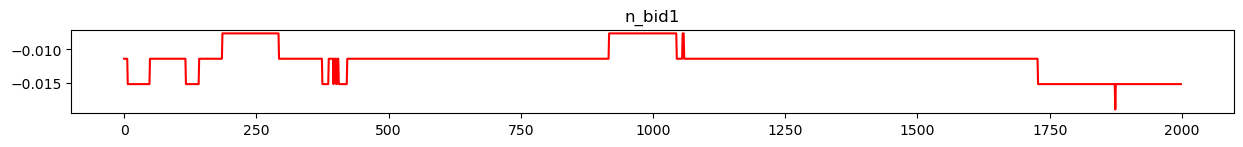

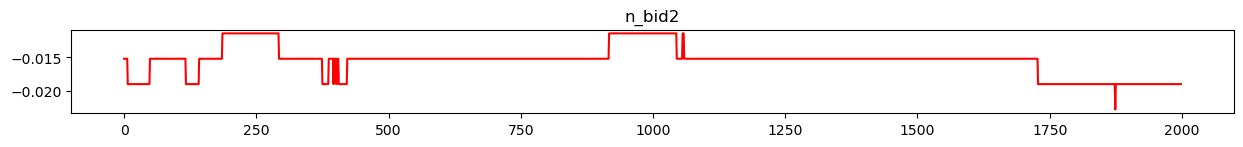

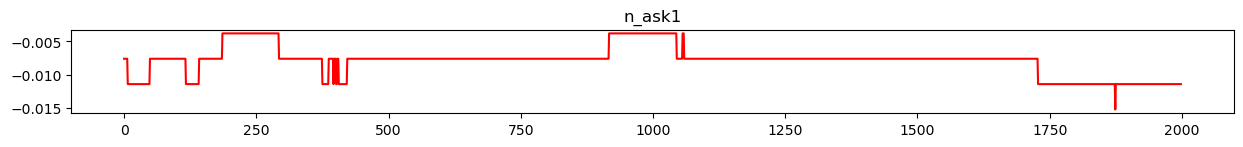

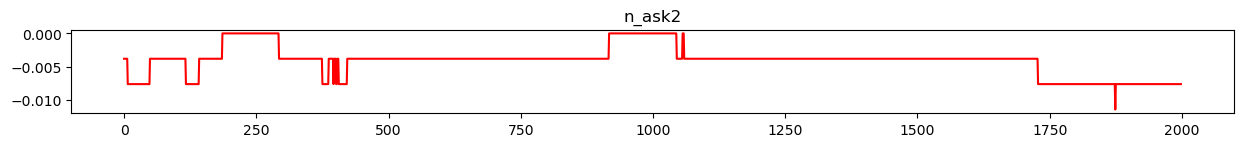

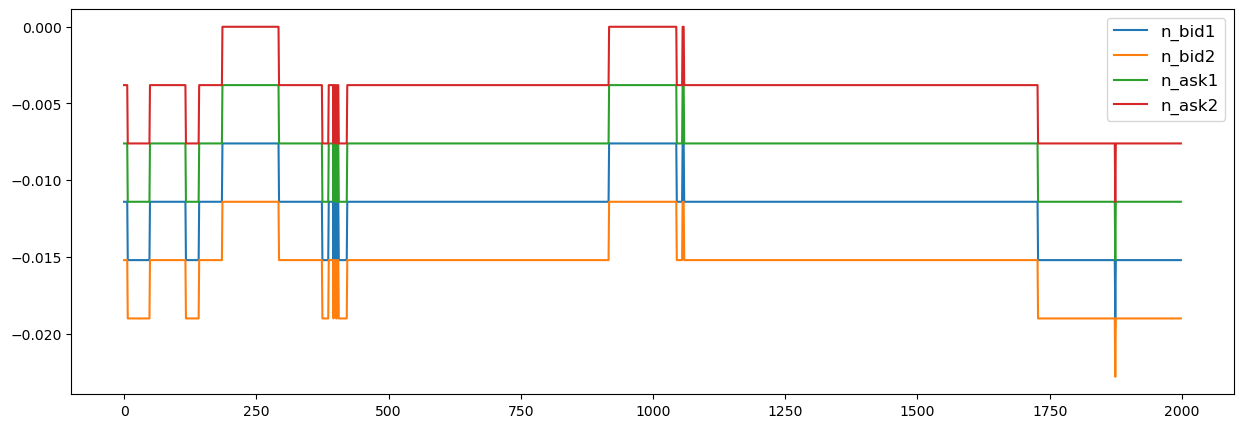

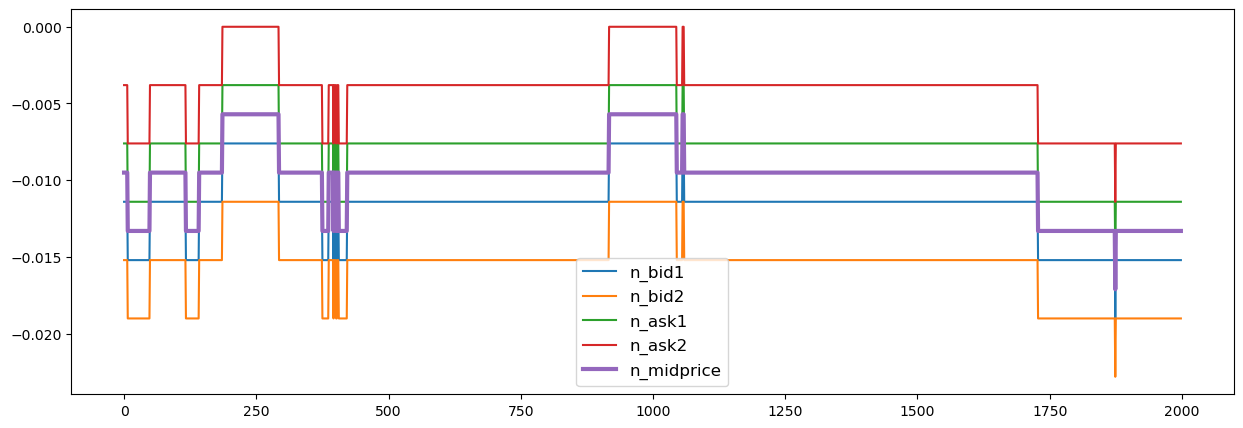

In [34]:
cols = ['n_bid1','n_bid2','n_ask1','n_ask2']
tmp_df = train[train['file']=='snapshot_sym1_date0_am.csv'].reset_index(drop=True)[-2000:]
tmp_df = tmp_df.reset_index(drop=True).reset_index()
for num, col in enumerate(cols):
    plt.figure(figsize=(15,5))
    plt.subplot(4,1,num+1)
    plt.plot(tmp_df['index'],tmp_df[col], color='red')
    plt.title(col)
plt.show()

plt.figure(figsize=(15,5))
for num, col in enumerate(cols):
    plt.plot(tmp_df['index'],tmp_df[col],label=col)
plt.legend(fontsize=12)

plt.figure(figsize=(15,5))
for num, col in enumerate(cols):
    plt.plot(tmp_df['index'],tmp_df[col],label=col)

plt.plot(tmp_df['index'],tmp_df['n_midprice'],label="n_midprice",lw=3)
plt.legend(fontsize=12)

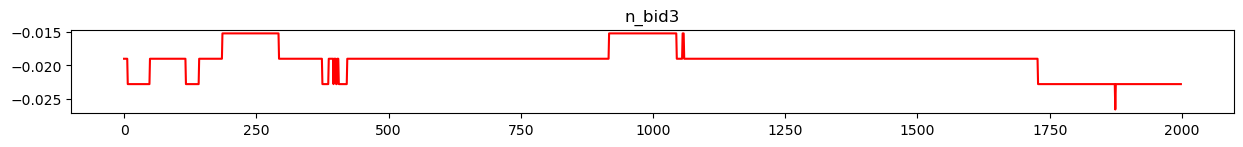

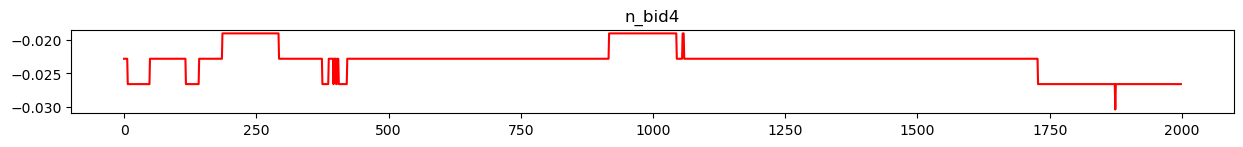

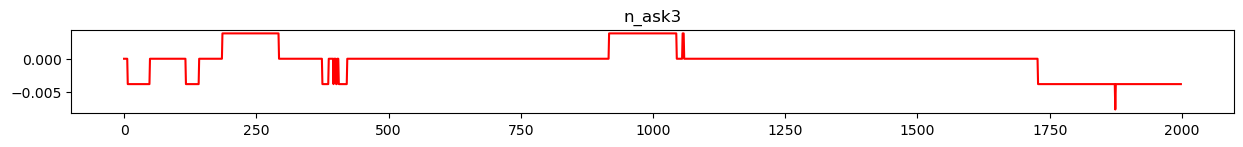

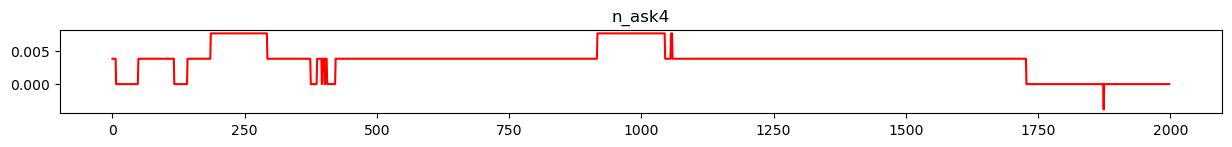

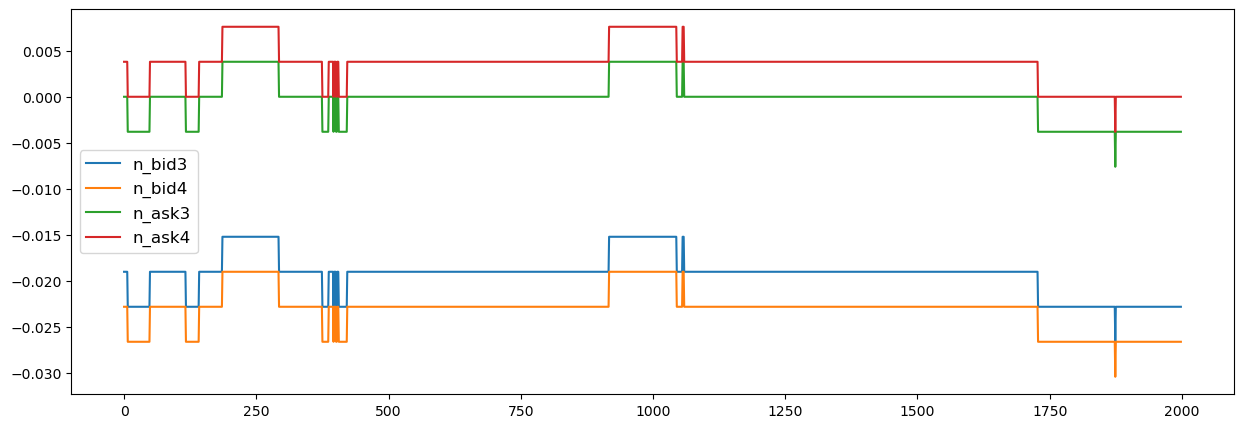

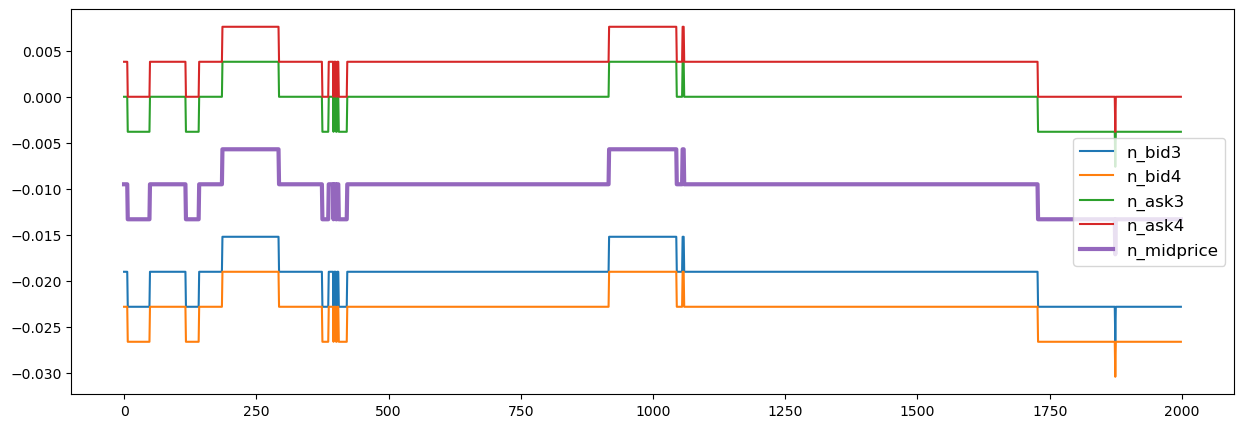

In [33]:
cols = ['n_bid3','n_bid4','n_ask3','n_ask4']
tmp_df = train[train['file']=='snapshot_sym1_date0_am.csv'].reset_index(drop=True)[-2000:]
tmp_df = tmp_df.reset_index(drop=True).reset_index()
for num, col in enumerate(cols):
    plt.figure(figsize=(15,5))
    plt.subplot(4,1,num+1)
    plt.plot(tmp_df['index'],tmp_df[col], color='red')
    plt.title(col)
plt.show()

plt.figure(figsize=(15,5))
for num, col in enumerate(cols):
    plt.plot(tmp_df['index'],tmp_df[col],label=col)
plt.legend(fontsize=12)

plt.figure(figsize=(15,5))
for num, col in enumerate(cols):
    plt.plot(tmp_df['index'],tmp_df[col],label=col)

plt.plot(tmp_df['index'],tmp_df['n_midprice'],label="n_midprice",lw=3)
plt.legend(fontsize=12)

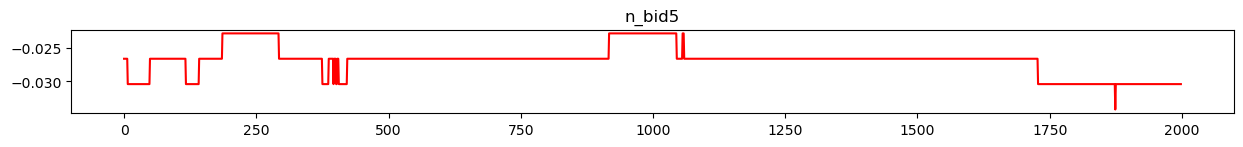

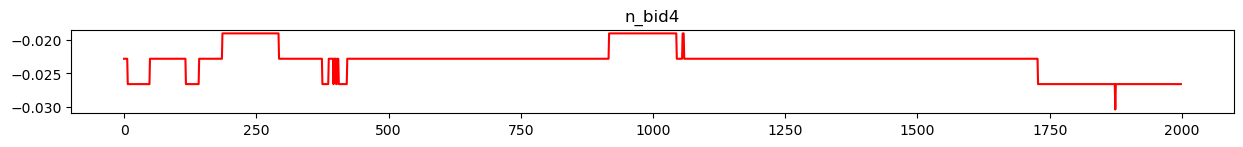

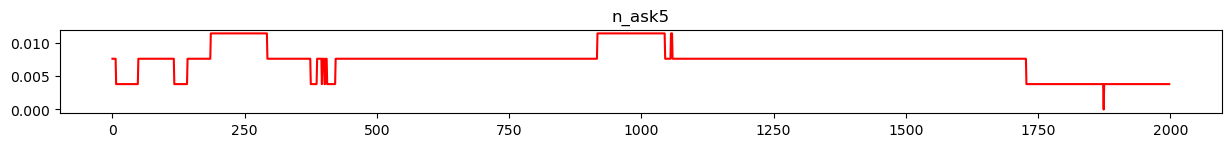

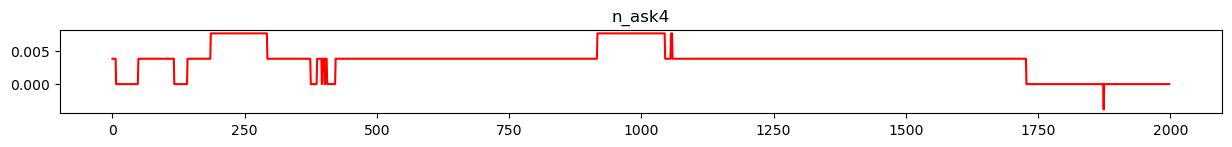

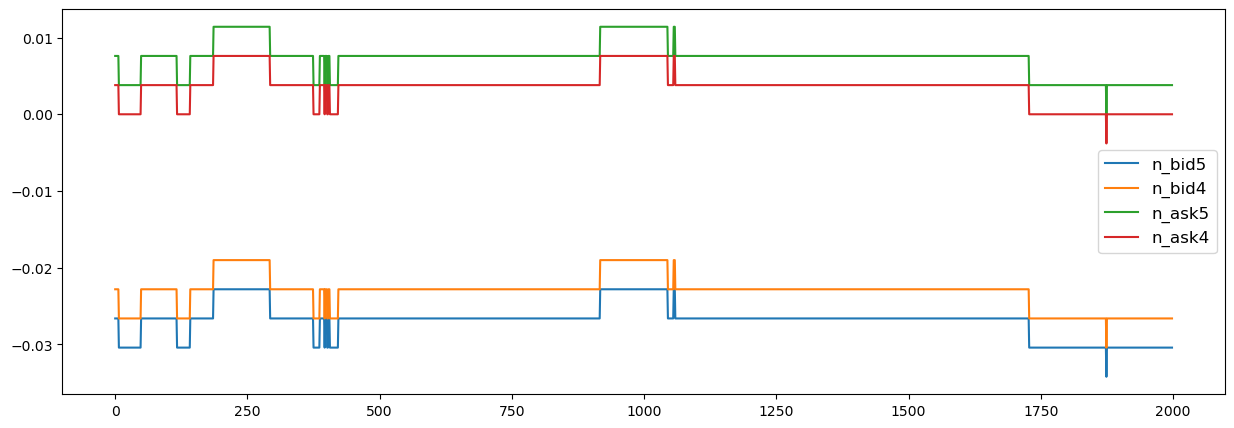

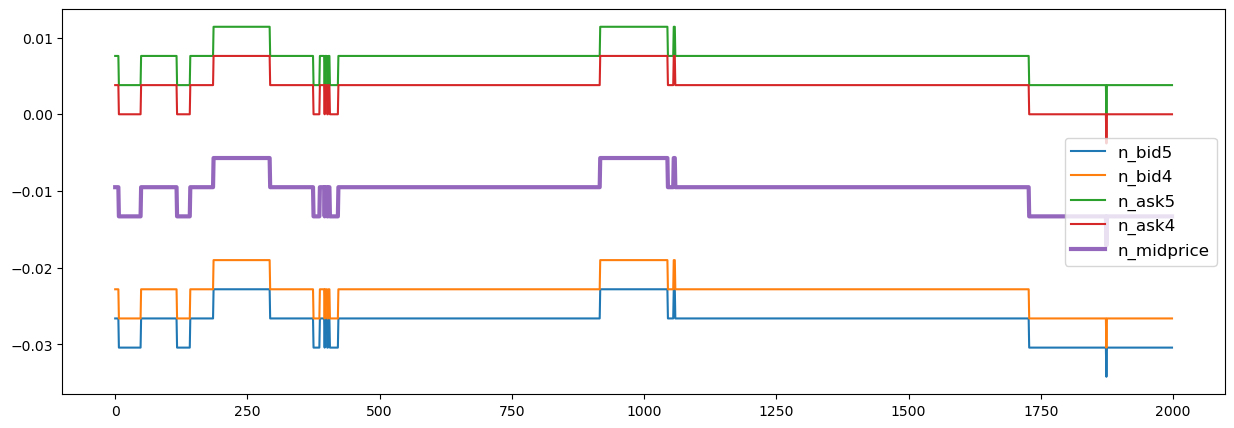

In [32]:
cols = ['n_bid5','n_bid4','n_ask5','n_ask4']
tmp_df = train[train['file']=='snapshot_sym1_date0_am.csv'].reset_index(drop=True)[-2000:]
tmp_df = tmp_df.reset_index(drop=True).reset_index()
for num, col in enumerate(cols):
    plt.figure(figsize=(15,5))
    plt.subplot(4,1,num+1)
    plt.plot(tmp_df['index'],tmp_df[col], color='red')
    plt.title(col)
plt.show()

plt.figure(figsize=(15,5))
for num, col in enumerate(cols):
    plt.plot(tmp_df['index'],tmp_df[col],label=col)
plt.legend(fontsize=12)

plt.figure(figsize=(15,5))
for num, col in enumerate(cols):
    plt.plot(tmp_df['index'],tmp_df[col],label=col)

plt.plot(tmp_df['index'],tmp_df['n_midprice'],label="n_midprice",lw=3)
plt.legend(fontsize=12)

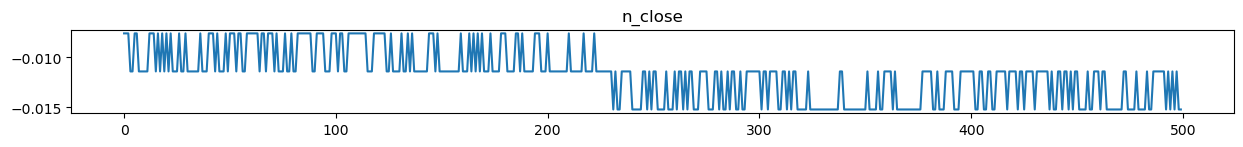

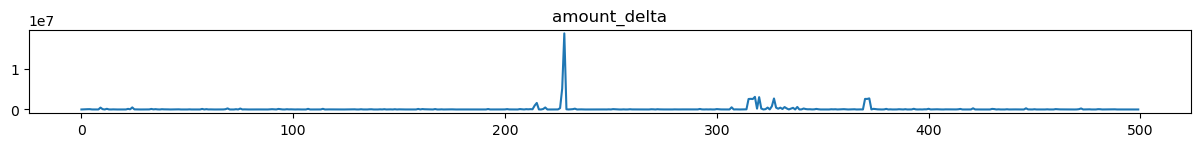

In [21]:
cols = ['n_close','amount_delta']
tmp_df = train[train['file']=='snapshot_sym1_date0_am.csv'].reset_index(drop=True)[-500:]
tmp_df = tmp_df.reset_index(drop=True).reset_index()
for num, col in enumerate(cols):
    plt.figure(figsize=(15,5))
    plt.subplot(4,1,num+1)
    plt.plot(tmp_df['index'],tmp_df[col])
    plt.title(col)
plt.show()

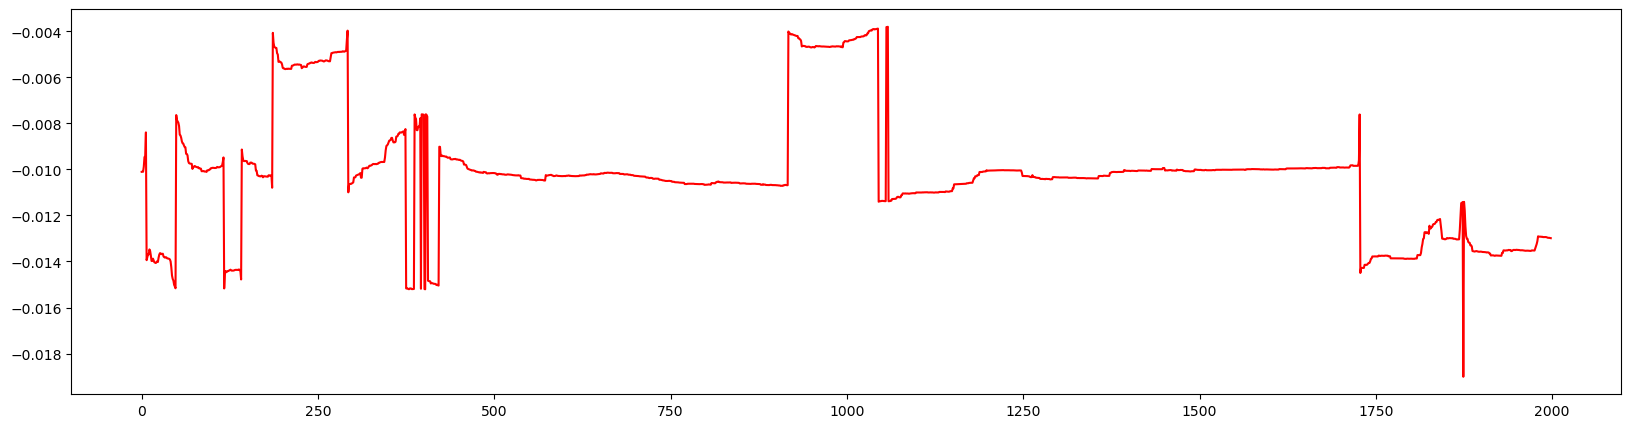

In [31]:
# 波动率是给定股票价格变化的重要统计指标，因此要计算价格变化，我们首先需要在固定间隔进行股票估值。
# 我们将使用已提供的数据的加权平均价格（WAP）进行可视化，WAP的变化反映股票波动情况。
train['wap1'] = (train['n_bid1']*train['n_bsize1'] + train['n_ask1']*train['n_asize1'])/(train['n_bsize1'] + train['n_asize1'])
test['wap1'] = (test['n_bid1']*test['n_bsize1'] + test['n_ask1']*test['n_asize1'])/(test['n_bsize1'] + test['n_asize1'])

tmp_df = train[train['file']=='snapshot_sym1_date0_am.csv'].reset_index(drop=True)[-2000:]
tmp_df = tmp_df.reset_index(drop=True).reset_index()
plt.figure(figsize=(20,5))
plt.plot(tmp_df['index'], tmp_df['wap1'], color='red')

In [45]:
# 时间相关特征
train['hour'] = train['time'].apply(lambda x:int(x.split(':')[0]))
test['hour'] = test['time'].apply(lambda x:int(x.split(':')[0]))

train['minute'] = train['time'].apply(lambda x:int(x.split(':')[1]))
test['minute'] = test['time'].apply(lambda x:int(x.split(':')[1]))


# 为了保证时间顺序的一致性，故进行排序
train = train.sort_values(['file','time'])
test = test.sort_values(['file','time'])

# 当前时间特征
# 围绕买卖价格和买卖量进行构建
# 暂时只构建买一卖一和买二卖二相关特征，进行优化时可以加上其余买卖信息
train['wap1'] = (train['n_bid1']*train['n_bsize1'] + train['n_ask1']*train['n_asize1'])/(train['n_bsize1'] + train['n_asize1'])
test['wap1'] = (test['n_bid1']*test['n_bsize1'] + test['n_ask1']*test['n_asize1'])/(test['n_bsize1'] + test['n_asize1'])

train['wap2'] = (train['n_bid2']*train['n_bsize2'] + train['n_ask2']*train['n_asize2'])/(train['n_bsize2'] + train['n_asize2'])
test['wap2'] = (test['n_bid2']*test['n_bsize2'] + test['n_ask2']*test['n_asize2'])/(test['n_bsize2'] + test['n_asize2'])

train['wap_balance'] = abs(train['wap1'] - train['wap2'])
train['price_spread'] = (train['n_ask1'] - train['n_bid1']) / ((train['n_ask1'] + train['n_bid1'])/2)
train['bid_spread'] = train['n_bid1'] - train['n_bid2']
train['ask_spread'] = train['n_ask1'] - train['n_ask2']
train['total_volume'] = (train['n_asize1'] + train['n_asize2']) + (train['n_bsize1'] + train['n_bsize2'])
train['volume_imbalance'] = abs((train['n_asize1'] + train['n_asize2']) - (train['n_bsize1'] + train['n_bsize2']))

test['wap_balance'] = abs(test['wap1'] - test['wap2'])
test['price_spread'] = (test['n_ask1'] - test['n_bid1']) / ((test['n_ask1'] + test['n_bid1'])/2)
test['bid_spread'] = test['n_bid1'] - test['n_bid2']
test['ask_spread'] = test['n_ask1'] - test['n_ask2']
test['total_volume'] = (test['n_asize1'] + test['n_asize2']) + (test['n_bsize1'] + test['n_bsize2'])
test['volume_imbalance'] = abs((test['n_asize1'] + test['n_asize2']) - (test['n_bsize1'] + test['n_bsize2']))

# 历史平移
# 获取历史信息
for val in ['wap1','wap2','wap_balance','price_spread','bid_spread','ask_spread','total_volume','volume_imbalance']:
    for loc in [1,5,10,20,40,60]:
        train[f'file_{val}_shift{loc}'] = train.groupby(['file'])[val].shift(loc)
        test[f'file_{val}_shift{loc}'] = test.groupby(['file'])[val].shift(loc)
    
# 差分特征
# 获取与历史数据的增长关系
for val in ['wap1','wap2','wap_balance','price_spread','bid_spread','ask_spread','total_volume','volume_imbalance']:
    for loc in [1,5,10,20,40,60]:
        train[f'file_{val}_diff{loc}'] = train.groupby(['file'])[val].diff(loc)
        test[f'file_{val}_diff{loc}'] = test.groupby(['file'])[val].diff(loc)
    
# 窗口统计
# 获取历史信息分布变化信息
# 可以尝试更多窗口大小已经统计方式，如min、max、median等
for val in ['wap1','wap2','wap_balance','price_spread','bid_spread','ask_spread','total_volume','volume_imbalance']:
    train[f'file_{val}_win7_mean'] = train.groupby(['file'])[val].transform(lambda x: x.rolling(window=7, min_periods=3).mean())
    train[f'file_{val}_win7_std'] = train.groupby(['file'])[val].transform(lambda x: x.rolling(window=7, min_periods=3).std())
    
    test[f'file_{val}_win7_mean'] = test.groupby(['file'])[val].transform(lambda x: x.rolling(window=7, min_periods=3).mean())
    test[f'file_{val}_win7_std'] = test.groupby(['file'])[val].transform(lambda x: x.rolling(window=7, min_periods=3).std())


In [49]:
def cv_model(clf, train_x, train_y, test_x, clf_name, seed = 2023):
    folds = 5
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)
    oof = np.zeros([train_x.shape[0], 3])
    test_predict = np.zeros([test_x.shape[0], 3])
    cv_scores = []
    
    for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
        print('************************************ {} ************************************'.format(str(i+1)))
        trn_x, trn_y, val_x, val_y = train_x.iloc[train_index], train_y[train_index], train_x.iloc[valid_index], train_y[valid_index]
        
        if clf_name == "lgb":
            train_matrix = clf.Dataset(trn_x, label=trn_y)
            valid_matrix = clf.Dataset(val_x, label=val_y)
            params = {
                'boosting_type': 'gbdt',
                'objective': 'multiclass',
                'num_class':3,
                'min_child_weight': 6,
                'num_leaves': 2 ** 6,
                'lambda_l2': 10,
                'feature_fraction': 0.8,
                'bagging_fraction': 0.8,
                'bagging_freq': 4,
                'learning_rate': 0.1,
                'seed': 2023,
                'nthread' : 16,
                'verbose' : -1,
            }
            model = clf.train(params, train_matrix, 200, valid_sets=[train_matrix, valid_matrix],
                              categorical_feature=[])
            val_pred = model.predict(val_x, num_iteration=model.best_iteration)
            test_pred = model.predict(test_x, num_iteration=model.best_iteration)
        
        if clf_name == "xgb":
            xgb_params = {
              'booster': 'gbtree', 
              'objective': 'multi:softprob',
              'num_class':3,
              'max_depth': 5,
              'lambda': 10,
              'subsample': 0.7,
              'colsample_bytree': 0.7,
              'colsample_bylevel': 0.7,
              'eta': 0.1,
              'tree_method': 'hist',
              'seed': 2023,
              'nthread': 16,
              }
            train_matrix = clf.DMatrix(trn_x , label=trn_y)
            valid_matrix = clf.DMatrix(val_x , label=val_y)
            test_matrix = clf.DMatrix(test_x)
            
            watchlist = [(train_matrix, 'train'),(valid_matrix, 'eval')]
            
            model = clf.train(xgb_params, train_matrix, num_boost_round=200, evals=watchlist)
            val_pred  = model.predict(valid_matrix)
            test_pred = model.predict(test_matrix)
            
        if clf_name == "cat":
            device = "CPU"
            params = {'learning_rate': 0.1, 'depth': 5, 'bootstrap_type':'Bernoulli','random_seed':2023,
                      'od_type': 'Iter', 'od_wait': 100, 'random_seed': 11, 'allow_writing_files': False,
                      'loss_function': 'MultiClass', "task_type": device}
            
            model = clf(iterations=200, **params)
            model.fit(trn_x, trn_y, eval_set=(val_x, val_y),
                      metric_period=50,
                      use_best_model=True, 
                      cat_features=[],
                      verbose=1)
            
            val_pred  = model.predict_proba(val_x)
            test_pred = model.predict_proba(test_x)
        
        oof[valid_index] = val_pred
        test_predict += test_pred / kf.n_splits
        
        F1_score = f1_score(val_y, np.argmax(val_pred, axis=1), average='macro')
        cv_scores.append(F1_score)
        print(cv_scores)
        
    return oof, test_predict
    
# 处理train_x和test_x中的NaN值
train = train.fillna(0)
test = test.fillna(0)

# 处理train_x和test_x中的Inf值
train = train.replace([np.inf, -np.inf], 0)
test = test.replace([np.inf, -np.inf], 0)

# 入模特征
cols = [f for f in test.columns if f not in ['uuid','time','file']]
for label in ['label_5','label_10','label_20','label_40','label_60']:
    print(f'=================== {label} ===================')
    # 选择lightgbm模型
    lgb_oof, lgb_test = cv_model(lgb, train[cols], train[label], test[cols], 'lgb')
    # 选择xgboost模型
    xgb_oof, xgb_test = cv_model(xgb, train[cols], train[label], test[cols], 'xgb')
    # 选择catboost模型
    cat_oof, cat_test = cv_model(CatBoostClassifier, train[cols], train[label], test[cols], 'cat')

    # 进行取平均融合
    final_test = (lgb_test + xgb_test + cat_test) / 3

    test[label] = np.argmax(final_test, axis=1)


=================== label_5 ===================
************************************ 1 ************************************
[1.0]
************************************ 2 ************************************
[1.0, 1.0]
************************************ 3 ************************************
[1.0, 1.0, 1.0]
************************************ 4 ************************************
[1.0, 1.0, 1.0, 1.0]
************************************ 5 ************************************
[1.0, 1.0, 1.0, 1.0, 1.0]
************************************ 1 ************************************
[0]	train-mlogloss:0.95704	eval-mlogloss:0.95676
[1]	train-mlogloss:0.84075	eval-mlogloss:0.84057
[2]	train-mlogloss:0.74061	eval-mlogloss:0.74038
[3]	train-mlogloss:0.66224	eval-mlogloss:0.66212
[4]	train-mlogloss:0.59088	eval-mlogloss:0.59087
[5]	train-mlogloss:0.52680	eval-mlogloss:0.52684
[6]	train-mlogloss:0.47299	eval-mlogloss:0.47303
[7]	train-mlogloss:0.42392	eval-mlogloss:0.42404
[8]	train-mlogloss:0.381

50:	learn: 0.0055382	test: 0.0054204	best: 0.0054204 (50)	total: 637ms	remaining: 1.86s
100:	learn: 0.0006219	test: 0.0005668	best: 0.0005668 (100)	total: 1.21s	remaining: 1.19s
150:	learn: 0.0003134	test: 0.0002785	best: 0.0002785 (150)	total: 1.81s	remaining: 587ms
199:	learn: 0.0002135	test: 0.0001883	best: 0.0001883 (199)	total: 2.39s	remaining: 0us

bestTest = 0.0001882735446
bestIteration = 199

[1.0]
************************************ 2 ************************************
0:	learn: 0.9112415	test: 0.9113564	best: 0.9113564 (0)	total: 12.8ms	remaining: 2.54s


50:	learn: 0.0055249	test: 0.0056152	best: 0.0056152 (50)	total: 645ms	remaining: 1.88s
100:	learn: 0.0005932	test: 0.0006232	best: 0.0006232 (100)	total: 1.23s	remaining: 1.2s
150:	learn: 0.0003088	test: 0.0003266	best: 0.0003266 (150)	total: 1.87s	remaining: 607ms
199:	learn: 0.0002124	test: 0.0002257	best: 0.0002257 (199)	total: 2.47s	remaining: 0us

bestTest = 0.0002257116677
bestIteration = 199

[1.0, 1.0]
************************************ 3 ************************************
0:	learn: 0.9111736	test: 0.9112988	best: 0.9112988 (0)	total: 13.5ms	remaining: 2.69s


50:	learn: 0.0055319	test: 0.0055581	best: 0.0055581 (50)	total: 677ms	remaining: 1.98s
100:	learn: 0.0005929	test: 0.0006159	best: 0.0006159 (100)	total: 1.28s	remaining: 1.26s
150:	learn: 0.0002927	test: 0.0003108	best: 0.0003108 (150)	total: 1.97s	remaining: 638ms
199:	learn: 0.0001977	test: 0.0002121	best: 0.0002121 (199)	total: 2.66s	remaining: 0us

bestTest = 0.0002121176455
bestIteration = 199

[1.0, 1.0, 1.0]
************************************ 4 ************************************
0:	learn: 0.9111818	test: 0.9114311	best: 0.9114311 (0)	total: 43.6ms	remaining: 8.67s


50:	learn: 0.0055274	test: 0.0055367	best: 0.0055367 (50)	total: 845ms	remaining: 2.47s
100:	learn: 0.0006031	test: 0.0006058	best: 0.0006058 (100)	total: 1.57s	remaining: 1.54s
150:	learn: 0.0003032	test: 0.0003057	best: 0.0003057 (150)	total: 2.16s	remaining: 700ms
199:	learn: 0.0002069	test: 0.0002089	best: 0.0002089 (199)	total: 2.76s	remaining: 0us

bestTest = 0.0002089394937
bestIteration = 199

[1.0, 1.0, 1.0, 1.0]
************************************ 5 ************************************
0:	learn: 0.9104130	test: 0.9106904	best: 0.9106904 (0)	total: 18.8ms	remaining: 3.73s


50:	learn: 0.0056683	test: 0.0058203	best: 0.0058203 (50)	total: 609ms	remaining: 1.78s
100:	learn: 0.0006226	test: 0.0006739	best: 0.0006739 (100)	total: 1.23s	remaining: 1.2s
150:	learn: 0.0002807	test: 0.0003090	best: 0.0003090 (150)	total: 1.82s	remaining: 590ms
199:	learn: 0.0001805	test: 0.0002012	best: 0.0002012 (199)	total: 2.42s	remaining: 0us

bestTest = 0.0002012186777
bestIteration = 199

[1.0, 1.0, 1.0, 1.0, 1.0]
=================== label_10 ===================
************************************ 1 ************************************
[1.0]
************************************ 2 ************************************
[1.0, 1.0]
************************************ 3 ************************************
[1.0, 1.0, 1.0]
************************************ 4 ************************************
[1.0, 1.0, 1.0, 1.0]
************************************ 5 ************************************
[1.0, 1.0, 1.0, 1.0, 1.0]
************************************ 1 **********************

50:	learn: 0.0057936	test: 0.0057551	best: 0.0057551 (50)	total: 644ms	remaining: 1.88s
100:	learn: 0.0006535	test: 0.0006288	best: 0.0006288 (100)	total: 1.28s	remaining: 1.26s
150:	learn: 0.0003351	test: 0.0003162	best: 0.0003162 (150)	total: 1.89s	remaining: 614ms
199:	learn: 0.0002328	test: 0.0002180	best: 0.0002180 (199)	total: 2.51s	remaining: 0us

bestTest = 0.0002179592525
bestIteration = 199

[1.0]
************************************ 2 ************************************
0:	learn: 0.9113475	test: 0.9111461	best: 0.9111461 (0)	total: 14.1ms	remaining: 2.81s


50:	learn: 0.0058195	test: 0.0057669	best: 0.0057669 (50)	total: 668ms	remaining: 1.95s
100:	learn: 0.0006568	test: 0.0006379	best: 0.0006379 (100)	total: 1.31s	remaining: 1.29s
150:	learn: 0.0003207	test: 0.0003084	best: 0.0003084 (150)	total: 1.91s	remaining: 621ms
199:	learn: 0.0002210	test: 0.0002113	best: 0.0002113 (199)	total: 2.56s	remaining: 0us

bestTest = 0.000211327774
bestIteration = 199

[1.0, 1.0]
************************************ 3 ************************************
0:	learn: 0.9112864	test: 0.9112414	best: 0.9112414 (0)	total: 12.9ms	remaining: 2.56s


50:	learn: 0.0058227	test: 0.0057502	best: 0.0057502 (50)	total: 638ms	remaining: 1.86s
100:	learn: 0.0006500	test: 0.0006314	best: 0.0006314 (100)	total: 1.29s	remaining: 1.26s
150:	learn: 0.0003277	test: 0.0003195	best: 0.0003195 (150)	total: 1.88s	remaining: 610ms
199:	learn: 0.0002268	test: 0.0002222	best: 0.0002222 (199)	total: 2.49s	remaining: 0us

bestTest = 0.0002222036651
bestIteration = 199

[1.0, 1.0, 1.0]
************************************ 4 ************************************
0:	learn: 0.9112697	test: 0.9116374	best: 0.9116374 (0)	total: 13.1ms	remaining: 2.61s


50:	learn: 0.0057872	test: 0.0058537	best: 0.0058537 (50)	total: 664ms	remaining: 1.94s
100:	learn: 0.0006519	test: 0.0006755	best: 0.0006755 (100)	total: 1.31s	remaining: 1.28s
150:	learn: 0.0003091	test: 0.0003196	best: 0.0003196 (150)	total: 1.93s	remaining: 627ms
199:	learn: 0.0002123	test: 0.0002179	best: 0.0002179 (199)	total: 2.6s	remaining: 0us

bestTest = 0.0002179374859
bestIteration = 199

[1.0, 1.0, 1.0, 1.0]
************************************ 5 ************************************
0:	learn: 0.9108863	test: 0.9112390	best: 0.9112390 (0)	total: 13.6ms	remaining: 2.71s


50:	learn: 0.0058290	test: 0.0060608	best: 0.0060608 (50)	total: 684ms	remaining: 2s
100:	learn: 0.0006495	test: 0.0007466	best: 0.0007466 (100)	total: 1.33s	remaining: 1.3s
150:	learn: 0.0003143	test: 0.0003796	best: 0.0003796 (150)	total: 1.95s	remaining: 633ms
199:	learn: 0.0002228	test: 0.0002756	best: 0.0002756 (199)	total: 2.57s	remaining: 0us

bestTest = 0.0002755781146
bestIteration = 199

[1.0, 1.0, 1.0, 1.0, 1.0]
=================== label_20 ===================
************************************ 1 ************************************
[1.0]
************************************ 2 ************************************
[1.0, 1.0]
************************************ 3 ************************************
[1.0, 1.0, 1.0]
************************************ 4 ************************************
[1.0, 1.0, 1.0, 1.0]
************************************ 5 ************************************
[1.0, 1.0, 1.0, 1.0, 1.0]
************************************ 1 *************************

50:	learn: 0.0059592	test: 0.0059024	best: 0.0059024 (50)	total: 632ms	remaining: 1.85s
100:	learn: 0.0006210	test: 0.0005918	best: 0.0005918 (100)	total: 1.27s	remaining: 1.24s
150:	learn: 0.0003201	test: 0.0002975	best: 0.0002975 (150)	total: 1.88s	remaining: 609ms
199:	learn: 0.0002306	test: 0.0002126	best: 0.0002126 (199)	total: 2.49s	remaining: 0us

bestTest = 0.0002126244112
bestIteration = 199

[1.0]
************************************ 2 ************************************
0:	learn: 0.9114224	test: 0.9113040	best: 0.9113040 (0)	total: 13ms	remaining: 2.59s


50:	learn: 0.0059648	test: 0.0059866	best: 0.0059866 (50)	total: 631ms	remaining: 1.84s
100:	learn: 0.0006102	test: 0.0006170	best: 0.0006170 (100)	total: 1.25s	remaining: 1.23s
150:	learn: 0.0003121	test: 0.0003224	best: 0.0003224 (150)	total: 1.83s	remaining: 595ms
199:	learn: 0.0002249	test: 0.0002346	best: 0.0002346 (199)	total: 2.44s	remaining: 0us

bestTest = 0.0002345655142
bestIteration = 199

[1.0, 1.0]
************************************ 3 ************************************
0:	learn: 0.9113727	test: 0.9112424	best: 0.9112424 (0)	total: 12.9ms	remaining: 2.56s


50:	learn: 0.0059781	test: 0.0059281	best: 0.0059281 (50)	total: 602ms	remaining: 1.76s
100:	learn: 0.0006268	test: 0.0006178	best: 0.0006178 (100)	total: 1.24s	remaining: 1.21s
150:	learn: 0.0003234	test: 0.0003199	best: 0.0003199 (150)	total: 1.84s	remaining: 597ms
199:	learn: 0.0002329	test: 0.0002311	best: 0.0002311 (199)	total: 2.44s	remaining: 0us

bestTest = 0.0002310861401
bestIteration = 199

[1.0, 1.0, 1.0]
************************************ 4 ************************************
0:	learn: 0.9113635	test: 0.9117058	best: 0.9117058 (0)	total: 12.7ms	remaining: 2.53s


50:	learn: 0.0059717	test: 0.0060633	best: 0.0060633 (50)	total: 618ms	remaining: 1.8s
100:	learn: 0.0005918	test: 0.0006155	best: 0.0006155 (100)	total: 1.25s	remaining: 1.22s
150:	learn: 0.0003049	test: 0.0003152	best: 0.0003152 (150)	total: 1.85s	remaining: 600ms
199:	learn: 0.0002203	test: 0.0002271	best: 0.0002271 (199)	total: 2.47s	remaining: 0us

bestTest = 0.0002271304105
bestIteration = 199

[1.0, 1.0, 1.0, 1.0]
************************************ 5 ************************************
0:	learn: 0.9109440	test: 0.9112013	best: 0.9112013 (0)	total: 20.2ms	remaining: 4.01s


50:	learn: 0.0058723	test: 0.0059730	best: 0.0059730 (50)	total: 622ms	remaining: 1.82s
100:	learn: 0.0006362	test: 0.0006731	best: 0.0006731 (100)	total: 1.22s	remaining: 1.2s
150:	learn: 0.0003251	test: 0.0003504	best: 0.0003504 (150)	total: 1.82s	remaining: 592ms
199:	learn: 0.0002191	test: 0.0002379	best: 0.0002379 (199)	total: 2.42s	remaining: 0us

bestTest = 0.0002379252167
bestIteration = 199

[1.0, 1.0, 1.0, 1.0, 1.0]
=================== label_40 ===================
************************************ 1 ************************************
[1.0]
************************************ 2 ************************************
[1.0, 1.0]
************************************ 3 ************************************
[1.0, 1.0, 1.0]
************************************ 4 ************************************
[1.0, 1.0, 1.0, 1.0]
************************************ 5 ************************************
[1.0, 1.0, 1.0, 1.0, 1.0]
************************************ 1 **********************

50:	learn: 0.0058167	test: 0.0058146	best: 0.0058146 (50)	total: 643ms	remaining: 1.88s
100:	learn: 0.0006489	test: 0.0006471	best: 0.0006471 (100)	total: 1.24s	remaining: 1.21s
150:	learn: 0.0003177	test: 0.0003180	best: 0.0003180 (150)	total: 1.86s	remaining: 605ms
199:	learn: 0.0002246	test: 0.0002247	best: 0.0002247 (199)	total: 2.44s	remaining: 0us

bestTest = 0.0002247350252
bestIteration = 199

[1.0]
************************************ 2 ************************************
0:	learn: 0.9114385	test: 0.9113573	best: 0.9113573 (0)	total: 13.4ms	remaining: 2.66s


50:	learn: 0.0058322	test: 0.0058056	best: 0.0058056 (50)	total: 647ms	remaining: 1.89s
100:	learn: 0.0006593	test: 0.0006512	best: 0.0006512 (100)	total: 1.27s	remaining: 1.24s
150:	learn: 0.0003226	test: 0.0003197	best: 0.0003197 (150)	total: 1.88s	remaining: 611ms
199:	learn: 0.0002276	test: 0.0002265	best: 0.0002265 (199)	total: 2.48s	remaining: 0us

bestTest = 0.0002264870394
bestIteration = 199

[1.0, 1.0]
************************************ 3 ************************************
0:	learn: 0.9113986	test: 0.9113400	best: 0.9113400 (0)	total: 26.6ms	remaining: 5.29s


50:	learn: 0.0058152	test: 0.0057722	best: 0.0057722 (50)	total: 717ms	remaining: 2.09s
100:	learn: 0.0006672	test: 0.0006563	best: 0.0006563 (100)	total: 1.5s	remaining: 1.47s
150:	learn: 0.0003177	test: 0.0003130	best: 0.0003130 (150)	total: 2.21s	remaining: 716ms
199:	learn: 0.0002233	test: 0.0002208	best: 0.0002208 (199)	total: 2.87s	remaining: 0us

bestTest = 0.0002207605646
bestIteration = 199

[1.0, 1.0, 1.0]
************************************ 4 ************************************
0:	learn: 0.9113992	test: 0.9115602	best: 0.9115602 (0)	total: 16ms	remaining: 3.19s


50:	learn: 0.0058259	test: 0.0058843	best: 0.0058843 (50)	total: 671ms	remaining: 1.96s
100:	learn: 0.0006604	test: 0.0006705	best: 0.0006705 (100)	total: 1.31s	remaining: 1.28s
150:	learn: 0.0003232	test: 0.0003241	best: 0.0003241 (150)	total: 1.91s	remaining: 618ms
199:	learn: 0.0002283	test: 0.0002280	best: 0.0002280 (199)	total: 2.51s	remaining: 0us

bestTest = 0.0002280471335
bestIteration = 199

[1.0, 1.0, 1.0, 1.0]
************************************ 5 ************************************
0:	learn: 0.9109784	test: 0.9112528	best: 0.9112528 (0)	total: 13ms	remaining: 2.59s


50:	learn: 0.0059740	test: 0.0060480	best: 0.0060480 (50)	total: 653ms	remaining: 1.91s
100:	learn: 0.0006652	test: 0.0006917	best: 0.0006917 (100)	total: 1.28s	remaining: 1.26s
150:	learn: 0.0003206	test: 0.0003390	best: 0.0003390 (150)	total: 1.89s	remaining: 614ms
199:	learn: 0.0002254	test: 0.0002404	best: 0.0002404 (199)	total: 2.52s	remaining: 0us

bestTest = 0.0002404052571
bestIteration = 199

[1.0, 1.0, 1.0, 1.0, 1.0]
=================== label_60 ===================
************************************ 1 ************************************
[1.0]
************************************ 2 ************************************
[1.0, 1.0]
************************************ 3 ************************************
[1.0, 1.0, 1.0]
************************************ 4 ************************************
[1.0, 1.0, 1.0, 1.0]
************************************ 5 ************************************
[1.0, 1.0, 1.0, 1.0, 1.0]
************************************ 1 *********************

50:	learn: 0.0058324	test: 0.0058439	best: 0.0058439 (50)	total: 632ms	remaining: 1.85s
100:	learn: 0.0006594	test: 0.0006617	best: 0.0006617 (100)	total: 1.29s	remaining: 1.26s
150:	learn: 0.0002935	test: 0.0002960	best: 0.0002960 (150)	total: 1.89s	remaining: 612ms
199:	learn: 0.0002040	test: 0.0002064	best: 0.0002064 (199)	total: 2.51s	remaining: 0us

bestTest = 0.0002063999238
bestIteration = 199

[1.0]
************************************ 2 ************************************


0:	learn: 0.9115522	test: 0.9116874	best: 0.9116874 (0)	total: 14.7ms	remaining: 2.93s
50:	learn: 0.0057955	test: 0.0057918	best: 0.0057918 (50)	total: 681ms	remaining: 1.99s
100:	learn: 0.0006567	test: 0.0006487	best: 0.0006487 (100)	total: 1.29s	remaining: 1.26s
150:	learn: 0.0003231	test: 0.0003186	best: 0.0003186 (150)	total: 1.92s	remaining: 624ms
199:	learn: 0.0002201	test: 0.0002162	best: 0.0002162 (199)	total: 2.51s	remaining: 0us

bestTest = 0.0002161911705
bestIteration = 199

[1.0, 1.0]
************************************ 3 ************************************
0:	learn: 0.9115280	test: 0.9113522	best: 0.9113522 (0)	total: 12.9ms	remaining: 2.56s


50:	learn: 0.0057939	test: 0.0057502	best: 0.0057502 (50)	total: 670ms	remaining: 1.96s
100:	learn: 0.0006587	test: 0.0006421	best: 0.0006421 (100)	total: 1.28s	remaining: 1.26s
150:	learn: 0.0003240	test: 0.0003121	best: 0.0003121 (150)	total: 1.92s	remaining: 624ms
199:	learn: 0.0002210	test: 0.0002120	best: 0.0002120 (199)	total: 2.51s	remaining: 0us

bestTest = 0.000211989279
bestIteration = 199

[1.0, 1.0, 1.0]
************************************ 4 ************************************
0:	learn: 0.9115185	test: 0.9117066	best: 0.9117066 (0)	total: 13.1ms	remaining: 2.6s


50:	learn: 0.0057897	test: 0.0058388	best: 0.0058388 (50)	total: 672ms	remaining: 1.96s
100:	learn: 0.0006689	test: 0.0006839	best: 0.0006839 (100)	total: 1.27s	remaining: 1.25s
150:	learn: 0.0003192	test: 0.0003280	best: 0.0003280 (150)	total: 1.9s	remaining: 616ms
199:	learn: 0.0002207	test: 0.0002278	best: 0.0002278 (199)	total: 2.49s	remaining: 0us

bestTest = 0.0002277927761
bestIteration = 199

[1.0, 1.0, 1.0, 1.0]
************************************ 5 ************************************
0:	learn: 0.9109869	test: 0.9111668	best: 0.9111668 (0)	total: 15.5ms	remaining: 3.08s


50:	learn: 0.0058805	test: 0.0059189	best: 0.0059189 (50)	total: 645ms	remaining: 1.89s
100:	learn: 0.0006213	test: 0.0006347	best: 0.0006347 (100)	total: 1.26s	remaining: 1.23s
150:	learn: 0.0003036	test: 0.0003138	best: 0.0003138 (150)	total: 1.88s	remaining: 609ms
199:	learn: 0.0002101	test: 0.0002183	best: 0.0002183 (199)	total: 2.48s	remaining: 0us

bestTest = 0.0002182640412
bestIteration = 199

[1.0, 1.0, 1.0, 1.0, 1.0]
